In [1]:
"""Compare PMF and PDF coagulation representations.

Builds PMF and PDF aerosols over a shared radius grid, configures Brownian
coagulation with both ``distribution_type="discrete"`` and
``distribution_type="continuous_pdf"``, runs short guarded steps, converts
between representations via ``get_pdf_distribution_in_pmf``, and plots
before/after concentrations in PMF and PDF units for side-by-side behavior
checks. Uses modest grids and a single short step to keep runtime quick.

Example:
    Execute the script to see matching PMF and PDF concentration curves
    before and after coagulation, enabling comparison across
    representations.
"""

'Compare PMF and PDF coagulation representations.\n\nBuilds PMF and PDF aerosols over a shared radius grid, configures Brownian\ncoagulation with both ``distribution_type="discrete"`` and\n``distribution_type="continuous_pdf"``, runs short guarded steps, converts\nbetween representations via ``get_pdf_distribution_in_pmf``, and plots\nbefore/after concentrations in PMF and PDF units for side-by-side behavior\nchecks. Uses modest grids and a single short step to keep runtime quick.\n\nExample:\n    Execute the script to see matching PMF and PDF concentration curves\n    before and after coagulation, enabling comparison across\n    representations.\n'

# Coagulation Pattern 4: PMF vs PDF

Compare Brownian coagulation for PMF (discrete) and PDF (continuous)
representations using the public builder pattern:

- `distribution_type="discrete"` → PMF
- `distribution_type="continuous_pdf"` → PDF

Both are wrapped in `par.dynamics.Coagulation`. We run short steps for speed
and show PMF↔PDF conversion for like-for-like comparison.

In [2]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
import matplotlib.pyplot as plt
import numpy as np
import particula as par
from scipy.integrate import trapezoid

## Build aerosols (PMF and PDF)

In [3]:
# Shared grid (modest resolution)
radius_bins = np.logspace(-8, -5, 150)  # m (10 nm to 10 um)

# Lognormal parameters (kept small for speed)
mode = np.array([120e-9])
gsd = np.array([1.5])
number_conc = np.array([1e10])  # m^-3 total

# PMF (number per bin)
concentration_pmf = par.particles.get_lognormal_pmf_distribution(
    x_values=radius_bins,
    mode=mode,
    geometric_standard_deviation=gsd,
    number_of_particles=number_conc,
)

# PDF (number per size)
concentration_pdf = par.particles.get_lognormal_pdf_distribution(
    x_values=radius_bins,
    mode=mode,
    geometric_standard_deviation=gsd,
    number_of_particles=number_conc,
)

# Atmosphere
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_temperature(25, "degC")
    .set_pressure(1, "atm")
    .build()
)

# PMF particles
particles_pmf = (
    par.particles.PresetParticleRadiusBuilder()
    .set_distribution_type("pmf")
    .set_radius_bins(radius_bins, radius_bins_units="m")
    .set_concentration(concentration_pmf, concentration_units="m^-3")
    .set_density(np.array([1_000.0]), density_units="kg/m^3")
    .set_charge(np.zeros_like(radius_bins))
    .build()
)

aerosol_pmf = par.Aerosol(atmosphere=atmosphere, particles=particles_pmf)

# PDF particles
particles_pdf = (
    par.particles.PresetParticleRadiusBuilder()
    .set_distribution_type("pdf")
    .set_radius_bins(radius_bins, radius_bins_units="m")
    .set_concentration(concentration_pdf, concentration_units="m^-3")
    .set_density(np.array([1_000.0]), density_units="kg/m^3")
    .set_charge(np.zeros_like(radius_bins))
    .build()
)

aerosol_pdf = par.Aerosol(atmosphere=atmosphere, particles=particles_pdf)

## Configure coagulation runnables

In [4]:
coagulation_pmf = par.dynamics.Coagulation(
    coagulation_strategy=(
        par.dynamics.BrownianCoagulationBuilder()
        .set_distribution_type("discrete")
        .build()
    )
)

coagulation_pdf = par.dynamics.Coagulation(
    coagulation_strategy=(
        par.dynamics.BrownianCoagulationBuilder()
        .set_distribution_type("continuous_pdf")
        .build()
    )
)

print(coagulation_pmf)
print(coagulation_pdf)

## Execute short coagulation steps

In [5]:
time_step = 3600  # seconds (1 hour)
sub_steps = 100

# PMF run
pmf_before = aerosol_pmf.particles.get_concentration()
aerosol_pmf_after = coagulation_pmf.execute(
    aerosol_pmf, time_step=time_step, sub_steps=sub_steps
)
pmf_after = aerosol_pmf_after.particles.get_concentration()

# PDF run
pdf_before = aerosol_pdf.particles.get_concentration()
aerosol_pdf_after = coagulation_pdf.execute(
    aerosol_pdf, time_step=time_step, sub_steps=sub_steps
)
pdf_after = aerosol_pdf_after.particles.get_concentration()

## Convert for apples-to-apples comparison

Convert PDF⇄PMF using `par.particles.get_pdf_distribution_in_pmf` so both
representations can be compared on the same units.

In [6]:
pdf_as_pmf_before = par.particles.get_pdf_distribution_in_pmf(
    x_array=radius_bins, distribution=pdf_before, to_pdf=False
)
pdf_as_pmf_after = par.particles.get_pdf_distribution_in_pmf(
    x_array=radius_bins, distribution=pdf_after, to_pdf=False
)

pmf_as_pdf_before = par.particles.get_pdf_distribution_in_pmf(
    x_array=radius_bins, distribution=pmf_before, to_pdf=True
)
pmf_as_pdf_after = par.particles.get_pdf_distribution_in_pmf(
    x_array=radius_bins, distribution=pmf_after, to_pdf=True
)

# Quick consistency check
number_pmf = pmf_before.sum()
number_pdf = trapezoid(pdf_before, x=radius_bins)
print(f"Total number PMF: {number_pmf:.2e} m^-3")
print(f"Total number PDF: {number_pdf:.2e} m^-3 (integrated)")

Total number PMF: 1.10e+10 m^-3
Total number PDF: 1.10e+10 m^-3 (integrated)


## Plots

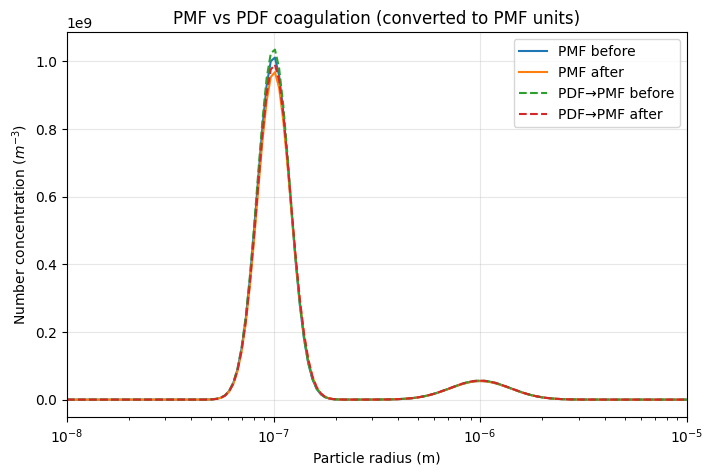

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(radius_bins, pmf_before, label="PMF before", color="tab:blue")
ax.plot(radius_bins, pmf_after, label="PMF after", color="tab:orange")
ax.plot(
    radius_bins,
    pdf_as_pmf_before,
    label="PDF→PMF before",
    color="tab:green",
    linestyle="--",
)
ax.plot(
    radius_bins,
    pdf_as_pmf_after,
    label="PDF→PMF after",
    color="tab:red",
    linestyle="--",
)
ax.set_xscale("log")
ax.set_xlim(1e-8, 1e-5)
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel(r"Number concentration ($m^{-3}$)")
ax.set_title("PMF vs PDF coagulation (converted to PMF units)")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

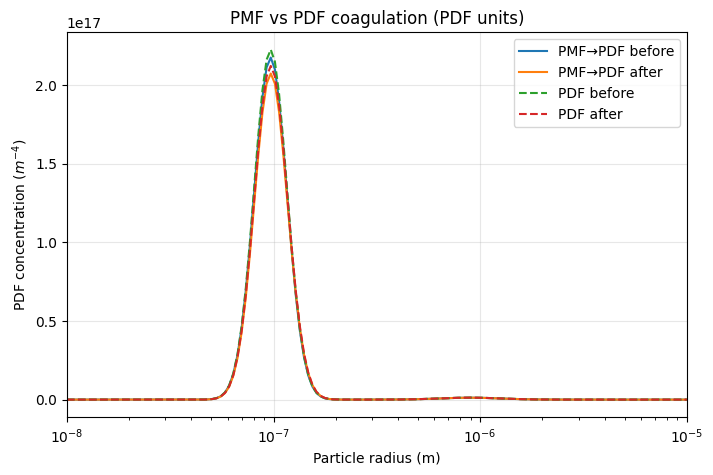

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    radius_bins, pmf_as_pdf_before, label="PMF→PDF before", color="tab:blue"
)
ax.plot(
    radius_bins, pmf_as_pdf_after, label="PMF→PDF after", color="tab:orange"
)
ax.plot(
    radius_bins,
    pdf_before,
    label="PDF before",
    color="tab:green",
    linestyle="--",
)
ax.plot(
    radius_bins, pdf_after, label="PDF after", color="tab:red", linestyle="--"
)
ax.set_xscale("log")
ax.set_xlim(1e-8, 1e-5)
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel(r"PDF concentration ($m^{-4}$)")
ax.set_title("PMF vs PDF coagulation (PDF units)")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

## Summary

- PMF: `distribution_type="discrete"` via `BrownianCoagulationBuilder`
- PDF: `distribution_type="continuous_pdf"`
- Both run through `par.dynamics.Coagulation`
- Conversions use `par.particles.get_pdf_distribution_in_pmf` for consistent
  comparisons across representations.
- Runtime with extended grids (10 nm–10 µm) and 1-hour step for visible
  coagulation effects.